# Transaction Preliminary Analysis
Author: Nivethan Iyer


In this notebook we conduct some preliminary analysis to gain some understanding about our data.

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/10/19 18:13:39 WARN Utils: Your hostname, NivethanAsus resolves to a loopback address: 127.0.1.1; using 172.27.67.33 instead (on interface eth0)
23/10/19 18:13:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 18:13:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/19 18:13:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
path1 = "../../../data/curated/all_data_combined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.count()
df.printSchema()


+-----------------+------------+--------------+-------+-----------+-------------+--------------+---------------+-----------------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----------------------------+--------------------------------------+----------------------------+-----------------------------------------------+-----------------------------------------------+------------------------------------+-------------------------------------------+------------------------------------------+-------------------------------------------+------------------------------------+
|consumer_postcode|merchant_abn|order_datetime|user_id|consumer_id|consumer_name|consumer_state|consumer_gender|transaction_dollar_value_$AUD|consumer_fraud_probability_%|       merchant_name|merchant_description|merchant_revenue_level|merchant_take_rate_%|             segment|merchant_fraud_probability_%|consumer_postcod

We group the data by merchants and collect the number of transactions they have 

In [6]:
# Grouping by the merchant_abn and counting the number of transactions for each merchant
from pyspark.sql import functions as F

# Aggregating to get both transaction count and total dollar value for each merchant
merchant_transaction = df.groupBy("merchant_abn").agg(
    F.count("order_datetime").alias("transaction_count"),
    F.sum("transaction_dollar_value_$AUD").alias("total_sales")
)

# Converting the result to a list
merchant_transaction_list = merchant_transaction.collect()
merchant_transaction_list

[Row(merchant_abn=83412691377, transaction_count=11928, total_sales=417137.3599999998),
 Row(merchant_abn=38700038932, transaction_count=4893, total_sales=5211864.72),
 Row(merchant_abn=73256306726, transaction_count=4360, total_sales=1236207.7899999998),
 Row(merchant_abn=41956465747, transaction_count=244, total_sales=55116.02999999999),
 Row(merchant_abn=19839532017, transaction_count=614, total_sales=96398.0),
 Row(merchant_abn=35344855546, transaction_count=1274, total_sales=113543.56999999998),
 Row(merchant_abn=73841664453, transaction_count=811, total_sales=69372.6),
 Row(merchant_abn=92202115241, transaction_count=98, total_sales=32377.46),
 Row(merchant_abn=34440496342, transaction_count=187, total_sales=16737.53),
 Row(merchant_abn=12516851436, transaction_count=179, total_sales=27899.65),
 Row(merchant_abn=96946925998, transaction_count=105, total_sales=98548.71),
 Row(merchant_abn=15613631617, transaction_count=1483, total_sales=450504.9699999999),
 Row(merchant_abn=482140

In [7]:
# Sorting the data by transaction count
sorted_transaction_list = sorted(merchant_transaction_list, key=lambda x: x.transaction_count)
num_unique_merchants = len(merchant_transaction_list)

# Average number of transactions
avg_transactions = sum([row.transaction_count for row in merchant_transaction_list]) / num_unique_merchants
# Minimum number of transactions
min_transactions = min([row.transaction_count for row in merchant_transaction_list])
# Maximum number of transactions
max_transactions = max([row.transaction_count for row in merchant_transaction_list])
# Quantiles (25th, 50th, and 75th percentiles)
transaction_counts = [row.transaction_count for row in merchant_transaction_list]

transaction_counts.sort()
q25 = transaction_counts[num_unique_merchants // 4]
q50 = transaction_counts[num_unique_merchants // 2]
q75 = transaction_counts[3 * num_unique_merchants // 4]
transaction_stats = {
    "Number of Unique Merchants": num_unique_merchants,
    "Average Transactions": avg_transactions,
    "Minimum Transactions": min_transactions,
    "Maximum Transactions": max_transactions,
    "25th Percentile": q25,
    "Median (50th Percentile)": q50,
    "75th Percentile": q75
}

transaction_stats


{'Number of Unique Merchants': 3909,
 'Average Transactions': 2892.0273727295985,
 'Minimum Transactions': 1,
 'Maximum Transactions': 241547,
 '25th Percentile': 79,
 'Median (50th Percentile)': 355,
 '75th Percentile': 1772}

There are 3909 unique merchants in our datasets and we also plot the number of transaction counts to get an idea of the distribution of number of transactions for our merchants


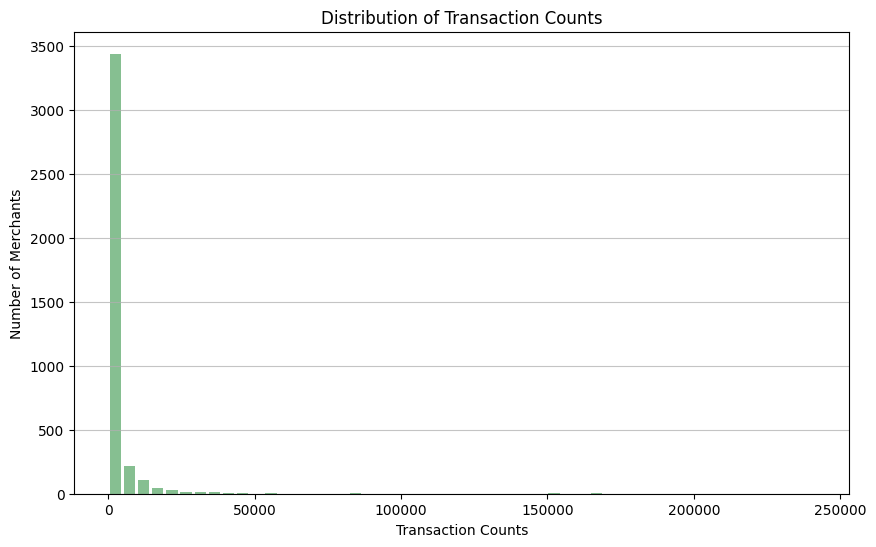

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting transaction counts for histogram
transaction_counts = [row['transaction_count'] for row in merchant_transaction_list]

plt.figure(figsize=(10,6))
plt.hist(transaction_counts, bins=50, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.grid(axis='y', alpha=0.75)
plt.show()





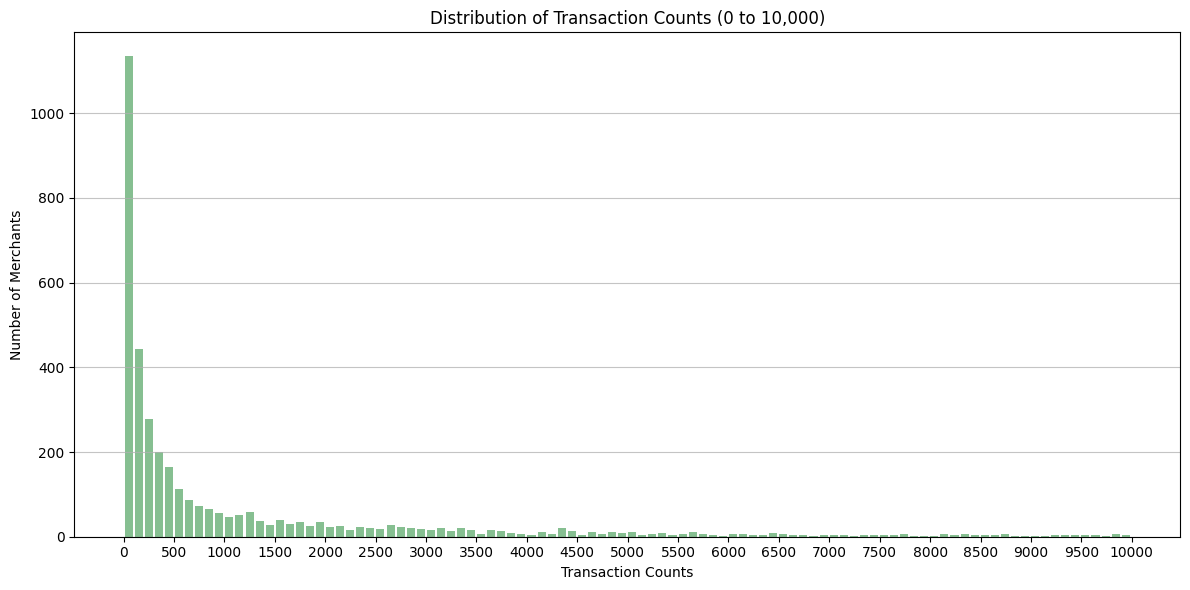

In [13]:
# Filtering transaction counts to values between 0 and 10000
filtered_transaction_counts = [count for count in transaction_counts if 0 <= count <= 10000]

plt.figure(figsize=(12,6))
plt.hist(filtered_transaction_counts, bins=100, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts (0 to 10,000)')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.xticks(np.arange(0, 10001, 500))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


As we can see there seems to be a right skew in our data with a small minority of merchants having more transactions that 3000. We will need to conduct analysis the dollar sales of these transactions which we will do in later steps.

In [14]:
spark.stop()